In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import wandb
from wandb.keras import WandbCallback

In [4]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

In [117]:
from projectwind.Energy_Forecast import WindowGenerator, get_LSTM_data
from projectwind.trainer import plot_loss

# Get Data

In [26]:
train_df, val_df, test_df = get_LSTM_data(25)

### Fetching 25xWTG data ###
### Fetching weather API data ###
### Preparing datasets ###


## Add adapted wind speeds

## Data analysis

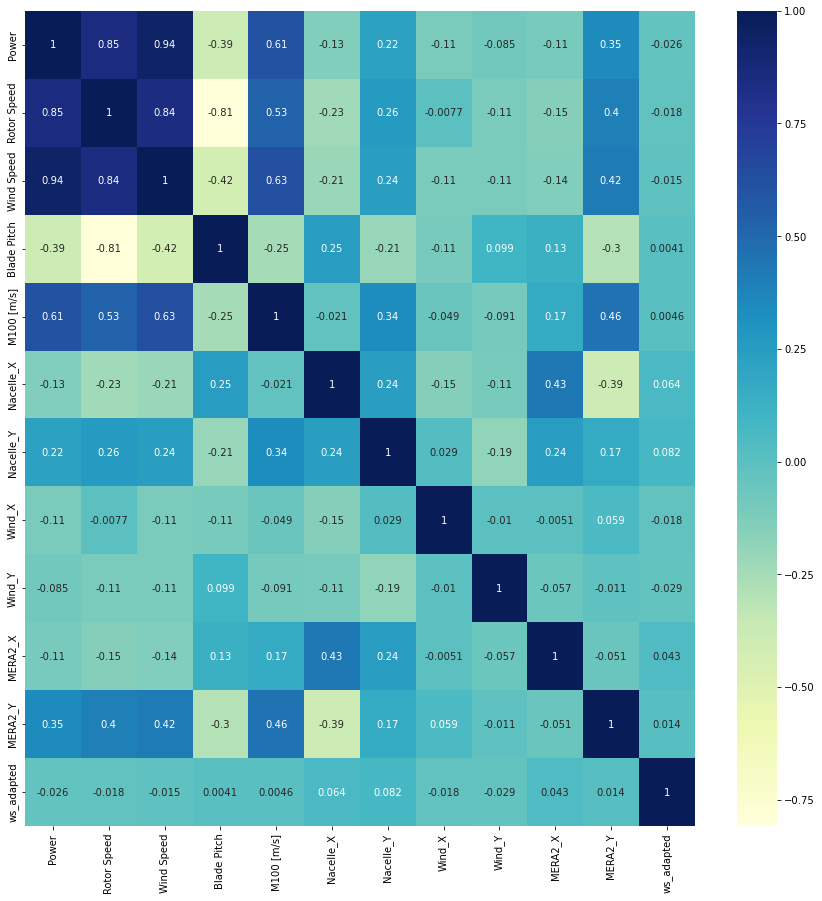

In [114]:
# 100m windspeeds - 2hr resampling
temp = train_df[0]

# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(axes=ax, data=temp.corr(), cmap="YlGnBu", annot=True);

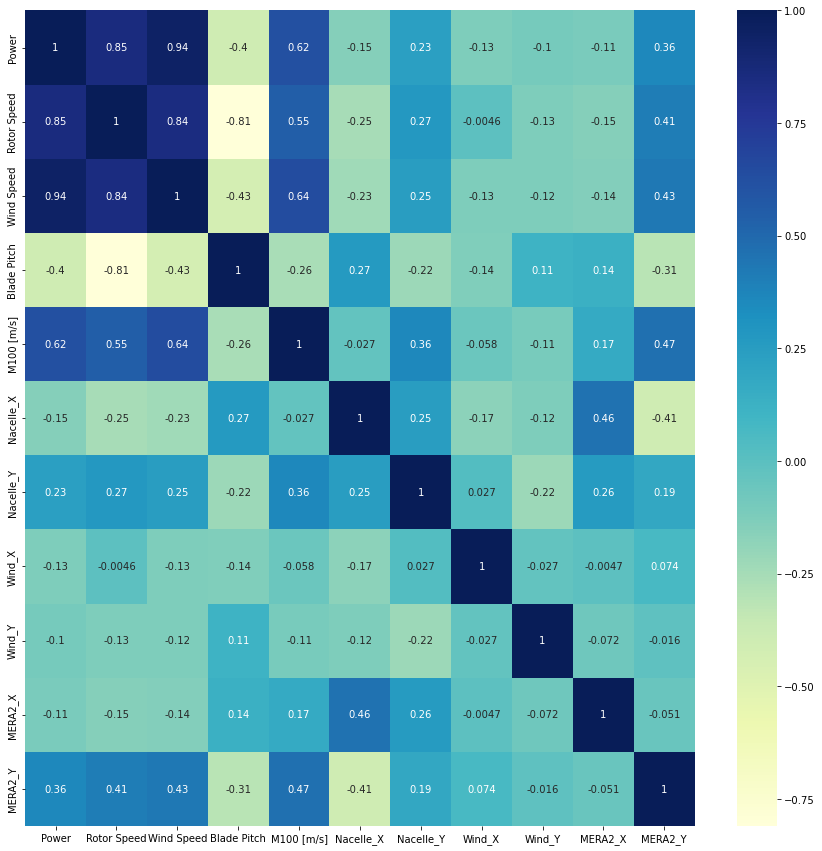

In [8]:
# 100m wind speeds
temp = train_df[0]

# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(axes=ax, data=temp.corr(), cmap="YlGnBu", annot=True);

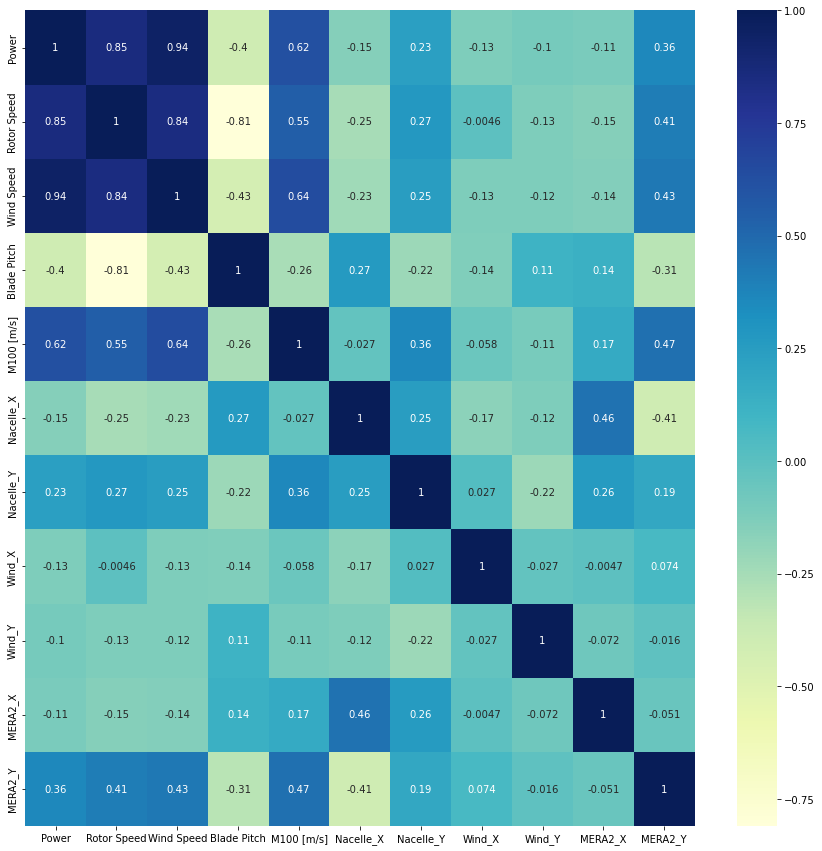

In [9]:
# 50m windspeeds
temp = train_df[0]

# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(axes=ax, data=temp.corr(), cmap="YlGnBu", annot=True);

## Select window and prepare sequences

In [118]:
n_steps_in = 3*24    # hrs 
n_steps_out = 6    # hrs

window = WindowGenerator(input_width=n_steps_in, label_width=n_steps_out, shift=n_steps_out,
                         train_df=train_df, val_df=val_df, test_df=test_df,
                         input_columns=['Power','Rotor Speed', 'Wind Speed', 'Blade Pitch', 'M100 [m/s]',
                                       'Nacelle_X', 'Nacelle_Y', 'Wind_X', 'Wind_Y', 'MERA2_X', 'MERA2_Y'],
                         forecast_columns=['M100 [m/s]'],
                         label_columns=['Power'])

In [186]:
# Box plot 
# Quartiles
# 

In [119]:
window

Total window size: 78
Input column name(s): ['Power', 'Rotor Speed', 'Wind Speed', 'Blade Pitch', 'M100 [m/s]', 'Nacelle_X', 'Nacelle_Y', 'Wind_X', 'Wind_Y', 'MERA2_X', 'MERA2_Y']
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Forecast column name(s): ['M100 [m/s]']
Forecast indices: [72 73 74 75 76 77]
Label column name(s): ['Power']
Label indices: [72 73 74 75 76 77]

In [197]:
X_train, X_fc_train, y_train =  window.train
X_val,  X_fc_val, y_val   =  window.val
X_test, X_fc_test, y_test  =  window.test

In [199]:
X_train.shape, X_fc_train.shape, y_train.shape

((4725, 72, 11), (4725, 6, 1), (4725,))

In [198]:
X_val.shape, X_fc_val.shape, y_val.shape

((1350, 72, 11), (1350, 6, 1), (1350,))

In [200]:
X_test.shape, X_fc_test.shape, y_test.shape

((675, 72, 11), (675, 6, 1), (675,))

## Find quartiles & make bins

In [230]:
y = np.concatenate([y_train, y_val, y_test])

In [231]:
targets = pd.DataFrame(data=y, columns=['Power'])

In [232]:
targets.describe()

,Power
count,6750.000000
mean,4557.658512
std,3143.380404
min,-61.996402
25%,1911.803478
50%,4080.426576
75%,6806.480255
max,12736.345703


In [233]:
targets['Power_bin'] = targets['Power'].apply(lambda x: 0 if x < 1900 else 1 if 1900 < x < 4000 else 2 if 4000 < x < 6800 else 4)

In [234]:
targets

,Power,Power_bin
0,6927.325439,4
1,4617.326416,2
2,1098.279907,0
3,3982.381256,1
4,334.934532,0
...,...,...
6745,5592.354492,2
6746,3827.087593,1
6747,-30.967310,0
6748,1446.266380,0


# Build Model

In [131]:
val_performance = pd.DataFrame()
test_performance = pd.DataFrame()

The models below combine two models (1) LSTM model for the performance of the wind turbine & (2) Dense model for the weather forecast. 

These two model outputs are concatenated & ran through two NN Dense layers to produce the output

In [17]:
# Passes LSTM states into combined model
def hybrid_model():
    
    # Performance model
    input_perf = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(input_perf)
    x_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(x_seq)
    #x_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(x_seq)
    #x_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(x_seq)
    x_perf = tf.keras.layers.GRU(64, return_sequences=False, dropout=0.2)(x_seq)
    #x_perf = tf.keras.layers.Reshape((32*X_train.shape[1],))(x_seq) # Reshape
    
    # Weather forecast model
    input_fc = tf.keras.layers.Input(shape=(n_steps_out, X_fc_train.shape[2]))
    x_fc_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(input_fc)
    x_fc_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(x_fc_seq)
    #x_fc_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(x_fc_seq)
    #x_fc_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(x_fc_seq)
    x_fc = tf.keras.layers.GRU(64, return_sequences=False, dropout=0.2)(x_fc_seq)
    #x_fc = tf.keras.layers.Reshape((32*X_fc_train.shape[1],))(x_fc_seq) # Reshape
    
    # Combined model
    combined = tf.keras.layers.concatenate([x_perf, x_fc], axis=1)
    x_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(combined)
    # x_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(x_seq)
    # x_seq = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(x_seq)
    # x = tf.keras.layers.GRU(64, return_sequences=False, dropout=0.2)(x_seq)
    x = tf.keras.layers.Dense(128, activation='relu')(combined)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(n_steps_out, activation="relu")(x)
    
    model = tf.keras.models.Model(inputs=[input_perf, input_fc], outputs=outputs)
    
    return model

In [18]:
# Passes LSTM states into combined model
def hybrid_model(): # Playful-spaceship-4
    
    # Performance model
    input_perf = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(input_perf)
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(x_seq)
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(x_seq)
    x_perf = tf.keras.layers.LSTM(32, return_sequences=False)(x_seq)
    #x_perf = tf.keras.layers.Reshape((32*X_train.shape[1],))(x_seq) # Reshape
    
    # Weather forecast model
    input_fc = tf.keras.layers.Input(shape=(n_steps_out, X_fc_train.shape[2]))
    x_fc_seq = tf.keras.layers.LSTM(32, return_sequences=True)(input_fc)
    x_fc = tf.keras.layers.LSTM(32, return_sequences=False)(x_fc_seq)
    x_fc = tf.keras.layers.Dense(32, activation='relu')(x_fc)
    x_fc = tf.keras.layers.Dense(32, activation='relu')(x_fc)
    x_fc = tf.keras.layers.Dense(6, activation='relu')(x_fc)
    #x_fc = tf.keras.layers.Reshape((32*X_fc_train.shape[1],))(x_fc_seq) # Reshape
    
    # Combined model
    combined = tf.keras.layers.concatenate([x_perf, x_fc], axis=1)
    x = tf.keras.layers.Dense(256, activation='relu')(combined)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(n_steps_out, activation="linear")(x)
    
    model = tf.keras.models.Model(inputs=[input_perf, input_fc], outputs=outputs)
    
    return model

In [19]:
# Passes LSTM states into combined model
def hybrid_model(): # leafy-plant-6
    
    # Performance model
    input_perf = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x_seq = tf.keras.layers.LSTM(128, return_sequences=True)(input_perf)
    x = tf.keras.layers.LSTM(128, return_sequences=False)(x_seq)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x_perf = tf.keras.layers.Dense(128, activation='relu')(x)
    #x_perf = tf.keras.layers.Reshape((1,X_train.shape[2]))(x_perf) # Reshape
    
    # Weather forecast model
    input_fc = tf.keras.layers.Input(shape=(n_steps_out, X_fc_train.shape[2]))
    x_seq = tf.keras.layers.LSTM(128, return_sequences=True)(input_fc)
    x_seq = tf.keras.layers.LSTM(128, return_sequences=True)(x_seq)
    x_seq = tf.keras.layers.LSTM(128, return_sequences=True)(x_seq)
    x_fc = tf.keras.layers.LSTM(128, return_sequences=False)(x_seq)
    
    # Combined model
    combined = tf.keras.layers.Multiply()([x_perf, x_fc])
    combined = tf.keras.layers.Reshape((128, 1))(combined)
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(combined)
    x = tf.keras.layers.LSTM(32, return_sequences=False)(x_seq)
    # x = tf.keras.layers.Dense(256, activation='relu')(combined)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(n_steps_out, activation="linear")(x)
    
    model = tf.keras.models.Model(inputs=[input_perf, input_fc], outputs=outputs)
    
    return model

In [20]:
# Passes LSTM states into combined model
def hybrid_model(): # fiery-dragon-5 with dropout
    
    # Performance model
    input_perf = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2)(input_perf)
    x = tf.keras.layers.LSTM(32, return_sequences=False, dropout=0.2)(x_seq)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x_perf = tf.keras.layers.Dense(12, activation='relu')(x)
    #x_perf = tf.keras.layers.Reshape((1,X_train.shape[2]))(x_perf) # Reshape
    
    # Weather forecast model
    input_fc = tf.keras.layers.Input(shape=(n_steps_out, X_fc_train.shape[2]))
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2)(input_fc)
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1)(x_seq)
    x_seq = tf.keras.layers.LSTM(24, return_sequences=True)(x_seq)
    x_fc = tf.keras.layers.LSTM(12, return_sequences=False)(x_seq)
    
    # Combined model
    combined = tf.keras.layers.Multiply()([x_perf, x_fc])
    outputs = tf.keras.layers.Dense(n_steps_out, activation="linear")(combined)
    
    model = tf.keras.models.Model(inputs=[input_perf, input_fc], outputs=outputs)
    
    return model

In [124]:
# Passes LSTM states into combined model
def hybrid_model(): # Best results with emw(span=12)
    
    # Performance model
    input_perf = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(input_perf)
    x = tf.keras.layers.LSTM(32, return_sequences=False)(x_seq)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x_perf = tf.keras.layers.Dense(4, activation='relu')(x)
    #x_perf = tf.keras.layers.Reshape((1,X_train.shape[2]))(x_perf) # Reshape
    
    # Weather forecast model
    input_fc = tf.keras.layers.Input(shape=(n_steps_out, X_fc_train.shape[2]))
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(input_fc)
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(x_seq)
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(x_seq)
    x_fc = tf.keras.layers.LSTM(32, return_sequences=False)(x_seq)
    
    # Combined model
    combined = tf.keras.layers.concatenate([x_perf, x_fc], axis=1)
    # combined = tf.keras.layers.Reshape((combined.shape[1],1))(combined) # Reshape
    # print(combined.shape)
    # x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(combined)
    # x = tf.keras.layers.LSTM(32, return_sequences=False)(x_seq)
    # x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    outputs = tf.keras.layers.Dense(1, activation="relu")(x)
    
    model = tf.keras.models.Model(inputs=[input_perf, input_fc], outputs=outputs)
    
    return model

# Run Model

In [125]:
hs_model=hybrid_model()
hs_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 72, 11)]     0                                            
__________________________________________________________________________________________________
lstm_18 (LSTM)                  (None, 72, 32)       5632        input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 32)           8320        lstm_18[0][0]                    
____________________________________________________________________________________________

In [126]:
wandb.init(project="energy_models", entity="shmiggit")

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▂
val_mean_absolute_error,█▄▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂
best_epoch,15
best_val_loss,244545.79688
epoch,65
loss,106631.25781
mean_absolute_error,247.03331
val_loss,282551.0625


In [127]:
model_name = 'Energy_model_proud-moon-54'

In [81]:
wandb.config = {
    "input_days": 3,
    "output_hours": 3,
    "resampling": '2H',
    "forecast": True,
    "shuffle": False,
    "model_type" : 'LSTM',
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 32
}

In [128]:
def compile_and_fit(model, window):
    
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=50,
                                                      mode='min',
                                                      restore_best_weights=True)

    # Reduce learning rate by an order of magnitude if val_loss does not improve for 20 epoch
    rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.1,
                                                 min_lr=1e-7,
                                                 verbose=1,
                                                 patience=5)
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    checkpoint=tf.keras.callbacks.ModelCheckpoint(f"./checkpoint/checkpoint_{model_name}.h5", save_best_only=True, save_weights_only=True)
    
    history = model.fit([X_train, X_fc_train], y_train, 
                        epochs=200,
                        validation_data=([X_val, X_fc_val], y_val),
                        #batch_size=32,
                        callbacks=[early_stopping, checkpoint, WandbCallback()])
    model.save(f'./checkpoint/{model_name}.h5')
    return history

In [129]:
model = hybrid_model()
history = compile_and_fit(model, window)

Epoch 1/200
148/148 [==============================] - 9s 23ms/step - loss: 25723434.0000 - mean_absolute_error: 4156.0928 - val_loss: 39184220.0000 - val_mean_absolute_error: 5140.8027
Epoch 2/200
148/148 [==============================] - 2s 14ms/step - loss: 14022688.0000 - mean_absolute_error: 2918.6208 - val_loss: 14926212.0000 - val_mean_absolute_error: 3109.8132
Epoch 3/200
148/148 [==============================] - 2s 14ms/step - loss: 5994334.5000 - mean_absolute_error: 1968.4774 - val_loss: 8314961.0000 - val_mean_absolute_error: 2344.7522
Epoch 4/200
148/148 [==============================] - 2s 14ms/step - loss: 4008467.5000 - mean_absolute_error: 1580.4878 - val_loss: 7574567.5000 - val_mean_absolute_error: 2267.8120
Epoch 5/200
148/148 [==============================] - 2s 14ms/step - loss: 3585158.5000 - mean_absolute_error: 1490.0508 - val_loss: 6761295.5000 - val_mean_absolute_error: 2054.1914
Epoch 6/200
148/148 [==============================] - 2s 14ms/step - loss: 

In [132]:
val_performance[model_name] = model.evaluate([X_val, X_fc_val], y_val)
test_performance[model_name] = model.evaluate([X_test, X_fc_test], y_test)

22/22 [==============================] - 0s 6ms/step - loss: 4202850.5000 - mean_absolute_error: 1731.0726


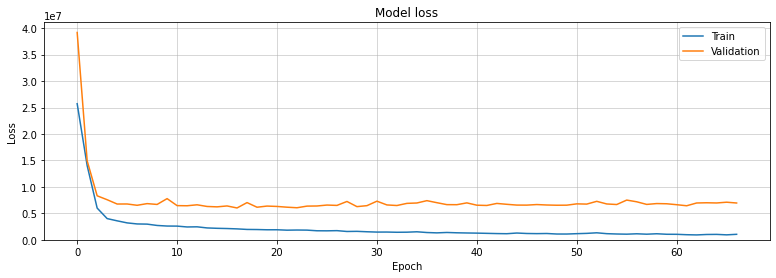

In [133]:
plot_loss(history)

In [167]:
y_pred = model.predict([X_val, X_fc_val], batch_size=1)

In [183]:
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], 1)

<AxesSubplot:>

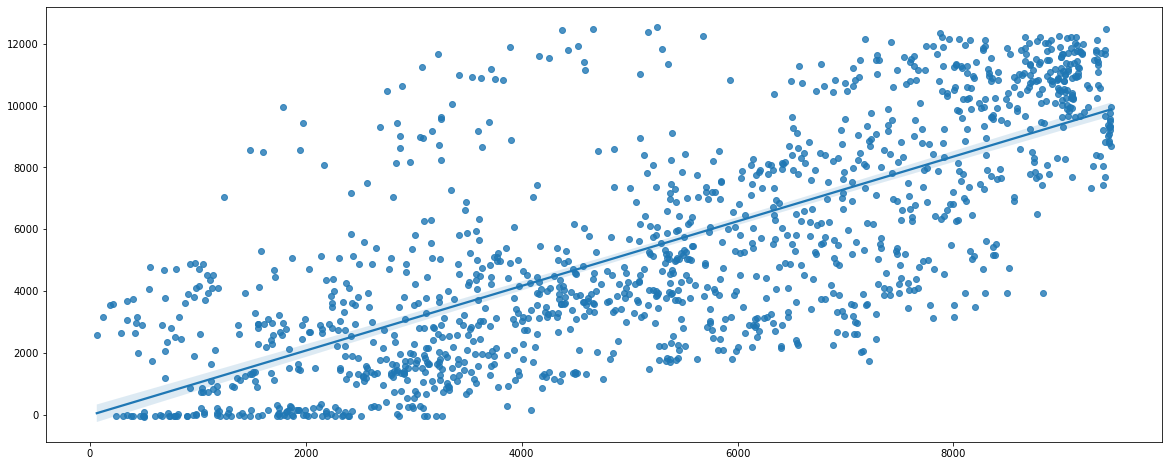

In [174]:
fig, ax = plt.subplots(figsize=(20,8))
sns.regplot(x=y_pred, y=y_val)

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x=window.input_indices, y=

array([[[11468.11254883]],

       [[ 1927.46747398]],

       [[ 5380.60375977]],

       ...,

       [[  922.81666183]],

       [[10500.89099121]],

       [[12133.90686035]]])

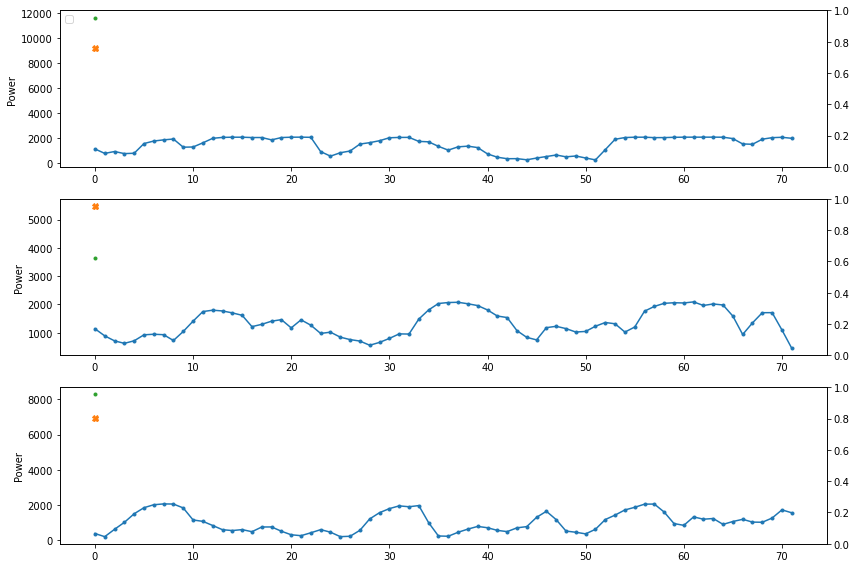

In [184]:
plot(X_val, X_fc_val, y_pred, y_val)

### Plot function

In [179]:
def plot(x_hist, x_fc, y_pred, y_true, max_subplots=3):
        plot_col = 'Power'
        plt.figure(figsize=(12, 8))
        label_indices = np.arange(0,1)
        plot_col_index = window.column_indices[plot_col]
        max_n = min(max_subplots, len(y_true))
        for n in range(max_n):
            i = np.random.randint(0,len(y_true))
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'Power')
            
            ax = plt.gca()
            ax2 = ax.twinx()
            ax2.set_ylim((0,1))
            #ax.right_ax.set_ylabel('Wind Speed [normed]')
            
            # Historical inputs
            ax.plot(window.input_indices, x_hist[i, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
            
            
#             # Forecast input
#             if window.forecast_columns:
#                 forecast_col_index = window.forecast_columns_indices.get('ws_adapted', None)
#             else:
#                 forecast_col_index = plot_col_index
            
#             ax2.plot(window.forecast_indices, x_fc[i, :, forecast_col_index],
#                      label='Forecast Inputs', marker='o', c='blue', zorder=-10)
            
            
            # Target
            if window.label_columns:
                label_col_index = window.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                label_col_index = -1
            
            # Label
            ax.plot(label_indices, y_true[i, : , label_col_index],
                        label='Labels', c='#2ca02c', marker='.')

            # Prediction
            ax.plot(label_indices, y_pred[i, : , label_col_index],
                        marker='X', label='Predictions', c='#ff7f0e')
            
            if n == 0:
                plt.legend(['Historical', 'Forecast', 'Label', 'Prediction'], loc="upper left")

            plt.xlabel('Time [h]')
            plt.tight_layout()

# Load Latest Model

In [ ]:
hn_model = tf.keras.models.load_model('./checkpoint/LSTM_Forecast_Hybrid_num_4Lx16N+18d_fc_2Lx54-18N_3x02do.h5')